In [4]:
!pip install xgboost


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
# Step 1: Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier


1.Data Understanding and Exploration

 Dataset Shape: (31700, 16)

 Meal Type Class Distribution:
 Meal_Type
snack        8001
breakfast    7970
dinner       7873
lunch        7856
Name: count, dtype: int64


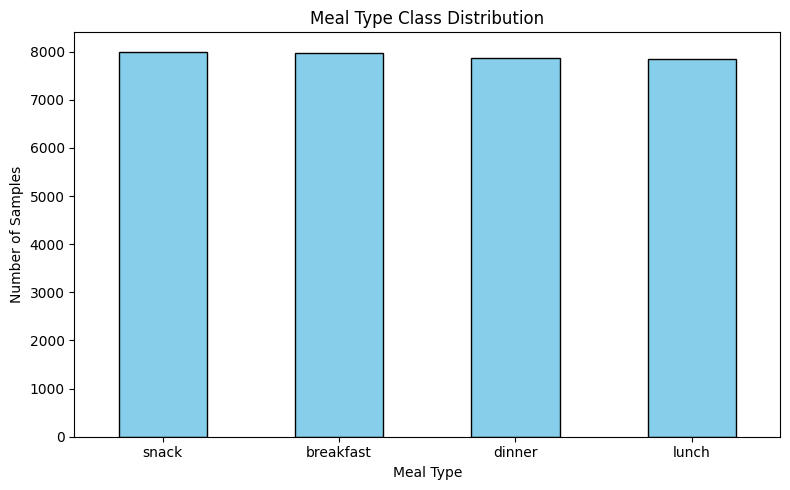

C:\Users\VishNiro\AppData\Local\Temp\ipykernel_15864\3726835891.py:24: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(3, random_state=1))



 Sampled Entries by Class:
     Meal_Type    Calories    Protein        Fat      Carbs      Sugar
0   breakfast  121.074935   1.497248   4.909268  13.113015   4.513605
1   breakfast  361.034654  20.039226  21.965404  27.186687   4.999519
2   breakfast  203.639059   6.693788   8.651226  23.515136   3.944240
3      dinner  278.948974   3.483856  15.418272  32.854096  15.015949
4      dinner  270.519798   4.702894  18.576904  32.426667  18.405099
5      dinner  267.341115  12.572105   9.610284  30.830441   5.329521
6       lunch  176.241243   3.454805   9.400803  27.672848  21.903157
7       lunch  115.056592   1.230405   0.322711  27.504620  13.864064
8       lunch  341.953703   9.542506  16.880339  32.284934   5.403596
9       snack  209.019739   3.465029  12.637229  18.764822  17.853307
10      snack  214.825870   3.436210  14.223003  22.559527  13.774919
11      snack  126.932506   3.787273   4.947039  13.659929   5.036138

 Missing Value Summary:
                     Missing Count  

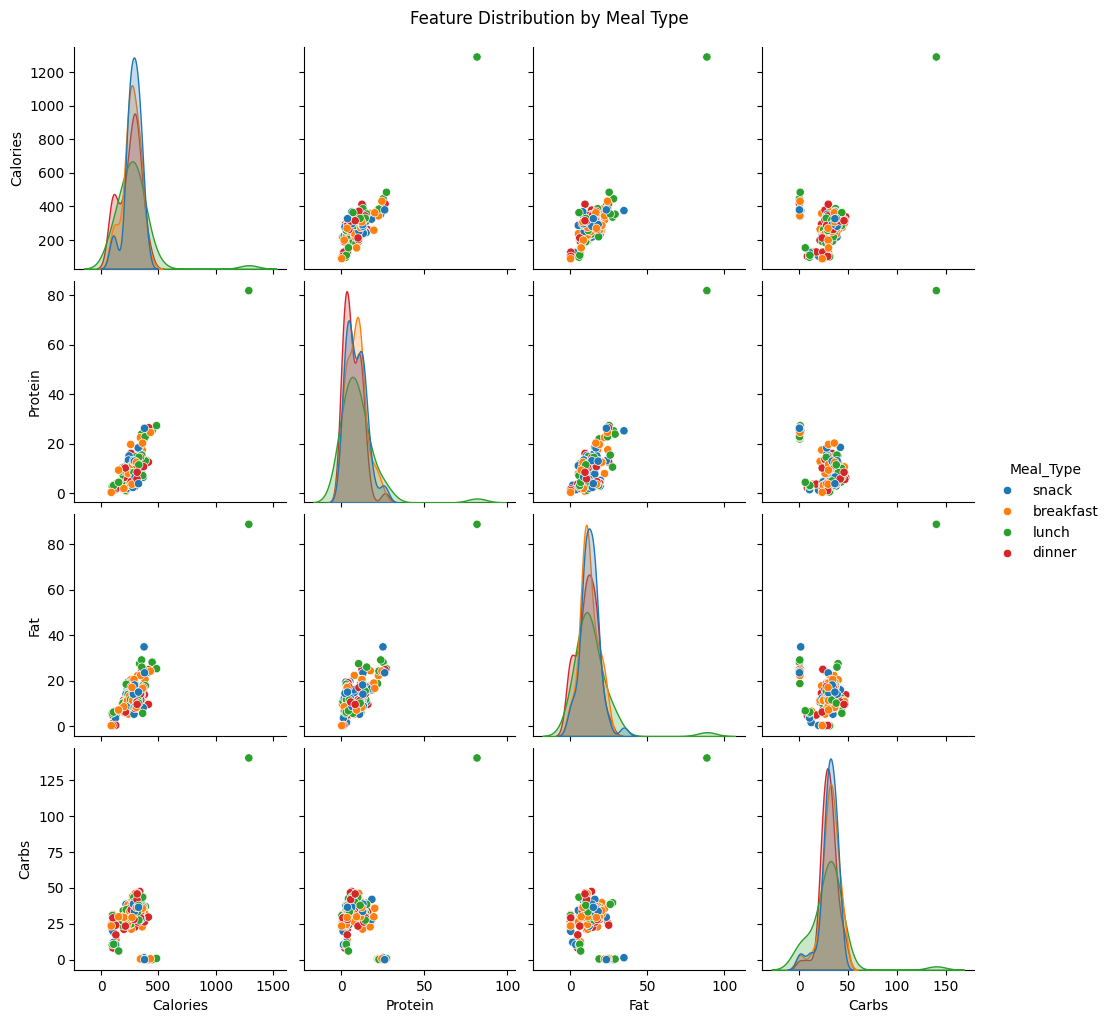

In [6]:
# Step 1: Load the Dataset
df = pd.read_csv(r"D:\Nirosha\GUVI\GUVI\Project_NutriClass\synthetic_food_dataset_imbalanced.csv")

# Step 2: Check Dataset Size
print(f" Dataset Shape: {df.shape}")

# Step 3: Examine Class Distribution (Meal_Type)
meal_type_distribution = df['Meal_Type'].value_counts()
print("\n Meal Type Class Distribution:\n", meal_type_distribution)

# Step 4: Visualize Class Distribution
plt.figure(figsize=(8, 5))
meal_type_distribution.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Meal Type Class Distribution')
plt.xlabel('Meal Type')
plt.ylabel('Number of Samples')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Step 5: Sample Entries from Each Class to Understand Inter-Class Variation
sampled_by_class = (
    df.groupby('Meal_Type', group_keys=False)
      .apply(lambda x: x.sample(3, random_state=1))
      .reset_index(drop=True)
)
print("\n Sampled Entries by Class:\n", sampled_by_class[['Meal_Type'] + df.columns[:5].tolist()])

# Step 6: Check Missing Values (Noise Indicator)
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100
missing_summary = pd.DataFrame({
    'Missing Count': missing_values,
    'Missing Percentage': missing_percentage
}).sort_values(by='Missing Count', ascending=False)
print("\n Missing Value Summary:\n", missing_summary)

# Step 7:  Visualize Inter-Class Variation for Some Features
numeric_features = df.select_dtypes(include=['float64']).columns[:4].tolist()
df_sampled = df.sample(n=200, random_state=42)
sns.pairplot(df_sampled, vars=numeric_features, hue='Meal_Type', diag_kind='kde')
plt.suptitle('Feature Distribution by Meal Type', y=1.02)
plt.show()

2.Data Preprocessing

In [7]:

# Step 1: Handle Missing Values
# Option A: Drop rows with any NaNs (or use imputation if needed)
df_clean = df.dropna() 

print(f" After dropping NaNs, shape = {df_clean.shape}")

# Step 4: Remove Duplicates
before_dupes = df_clean.shape[0]
df_clean = df_clean.drop_duplicates()
after_dupes = df_clean.shape[0]
print(f" Removed {before_dupes - after_dupes} duplicate rows")

# Step 2: Detect and Remove Outliers using IQR
numeric_cols = df_clean.select_dtypes(include=['float64', 'int64']).columns
for col in numeric_cols:
    Q1 = df_clean[col].quantile(0.25)
    Q3 = df_clean[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Cap the outliers instead of dropping
    df_clean[col] = np.where(df_clean[col] < lower_bound, lower_bound, df_clean[col])
    df_clean[col] = np.where(df_clean[col] > upper_bound, upper_bound, df_clean[col])

print(" Outliers capped using IQR method.")

# Step 3: Normalize or Standardize Numeric Features
scaler = StandardScaler()
df_scaled = df_clean.copy()
df_scaled[numeric_cols] = scaler.fit_transform(df_scaled[numeric_cols])
print(" Numerical features standardized.")

#Show summary of cleaned and scaled dataset
display(df_scaled.head())

 After dropping NaNs, shape = (31325, 16)
 Removed 65 duplicate rows
 Outliers capped using IQR method.
 Numerical features standardized.


,Calories,Protein,Fat,Carbs,Sugar,Fiber,Sodium,Cholesterol,Glycemic_Index,Water_Content,Serving_Size,Meal_Type,Preparation_Method,Is_Vegan,Is_Gluten_Free,Food_Name
0,0.243576,0.834198,0.316105,0.733546,-0.532189,-0.401741,1.145443,-0.008157,1.139762,-0.093082,1.087768,dinner,fried,False,False,Pizza
1,-0.646338,-0.821775,-0.073692,-0.719505,1.249645,-1.274201,-0.923981,0.533565,0.275661,0.245361,-1.021518,snack,raw,False,True,Ice Cream
2,0.703548,0.832039,1.177790,0.035528,-0.312068,-0.775148,1.201267,0.563538,-0.224022,-0.540771,1.119706,snack,raw,False,False,Burger
3,-0.812757,0.045265,-1.020176,0.351366,-0.817320,-0.086882,-0.094122,0.196672,0.215897,0.857431,-0.304130,lunch,fried,False,True,Sushi
4,0.061019,-0.495939,0.640045,0.068994,1.405117,-0.270816,-0.109972,-0.565925,0.337497,-1.103785,-1.714904,snack,baked,False,False,Donut


3.Feature Engineering

 Class Labels Encoded: ['breakfast', 'dinner', 'lunch', 'snack']


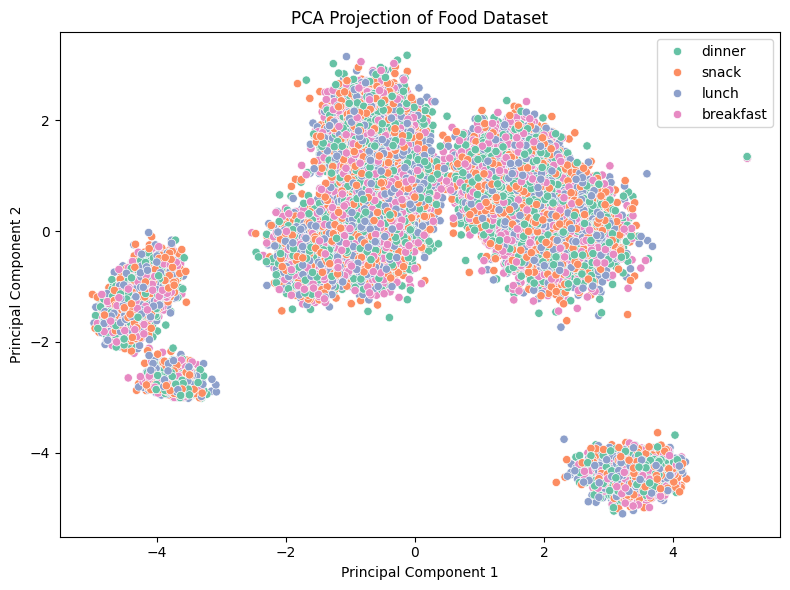

 Explained Variance Ratio: [0.37045527 0.2010134 ]


In [8]:

# Step 1: Encode the Target Column (Meal_Type)
label_encoder = LabelEncoder()
df_clean['Meal_Type_Label'] = label_encoder.fit_transform(df_clean['Meal_Type'])
print(" Class Labels Encoded:", list(label_encoder.classes_))

# Step 2: Select Numeric Features
numeric_cols = df_clean.select_dtypes(include=['float64', 'int64']).columns
X = df_clean[numeric_cols]

# Step 3: Standardize the Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 4: Apply PCA to Reduce Dimensionality
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Step 5: Visualize the PCA Output
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['Meal_Type'] = df_clean['Meal_Type']

plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Meal_Type', palette='Set2')
plt.title("PCA Projection of Food Dataset")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.tight_layout()
plt.show()

# Show explained variance
print(" Explained Variance Ratio:", pca.explained_variance_ratio_)


4.Model Selection and Training


 Training: Logistic Regression
 Accuracy: 1.0000
              precision    recall  f1-score   support

   breakfast       1.00      1.00      1.00      1637
      dinner       1.00      1.00      1.00      1537
       lunch       1.00      1.00      1.00      1482
       snack       1.00      1.00      1.00      1596

    accuracy                           1.00      6252
   macro avg       1.00      1.00      1.00      6252
weighted avg       1.00      1.00      1.00      6252


 Training: Decision Tree
 Accuracy: 1.0000
              precision    recall  f1-score   support

   breakfast       1.00      1.00      1.00      1637
      dinner       1.00      1.00      1.00      1537
       lunch       1.00      1.00      1.00      1482
       snack       1.00      1.00      1.00      1596

    accuracy                           1.00      6252
   macro avg       1.00      1.00      1.00      6252
weighted avg       1.00      1.00      1.00      6252


 Training: Random Forest
 Accuracy:

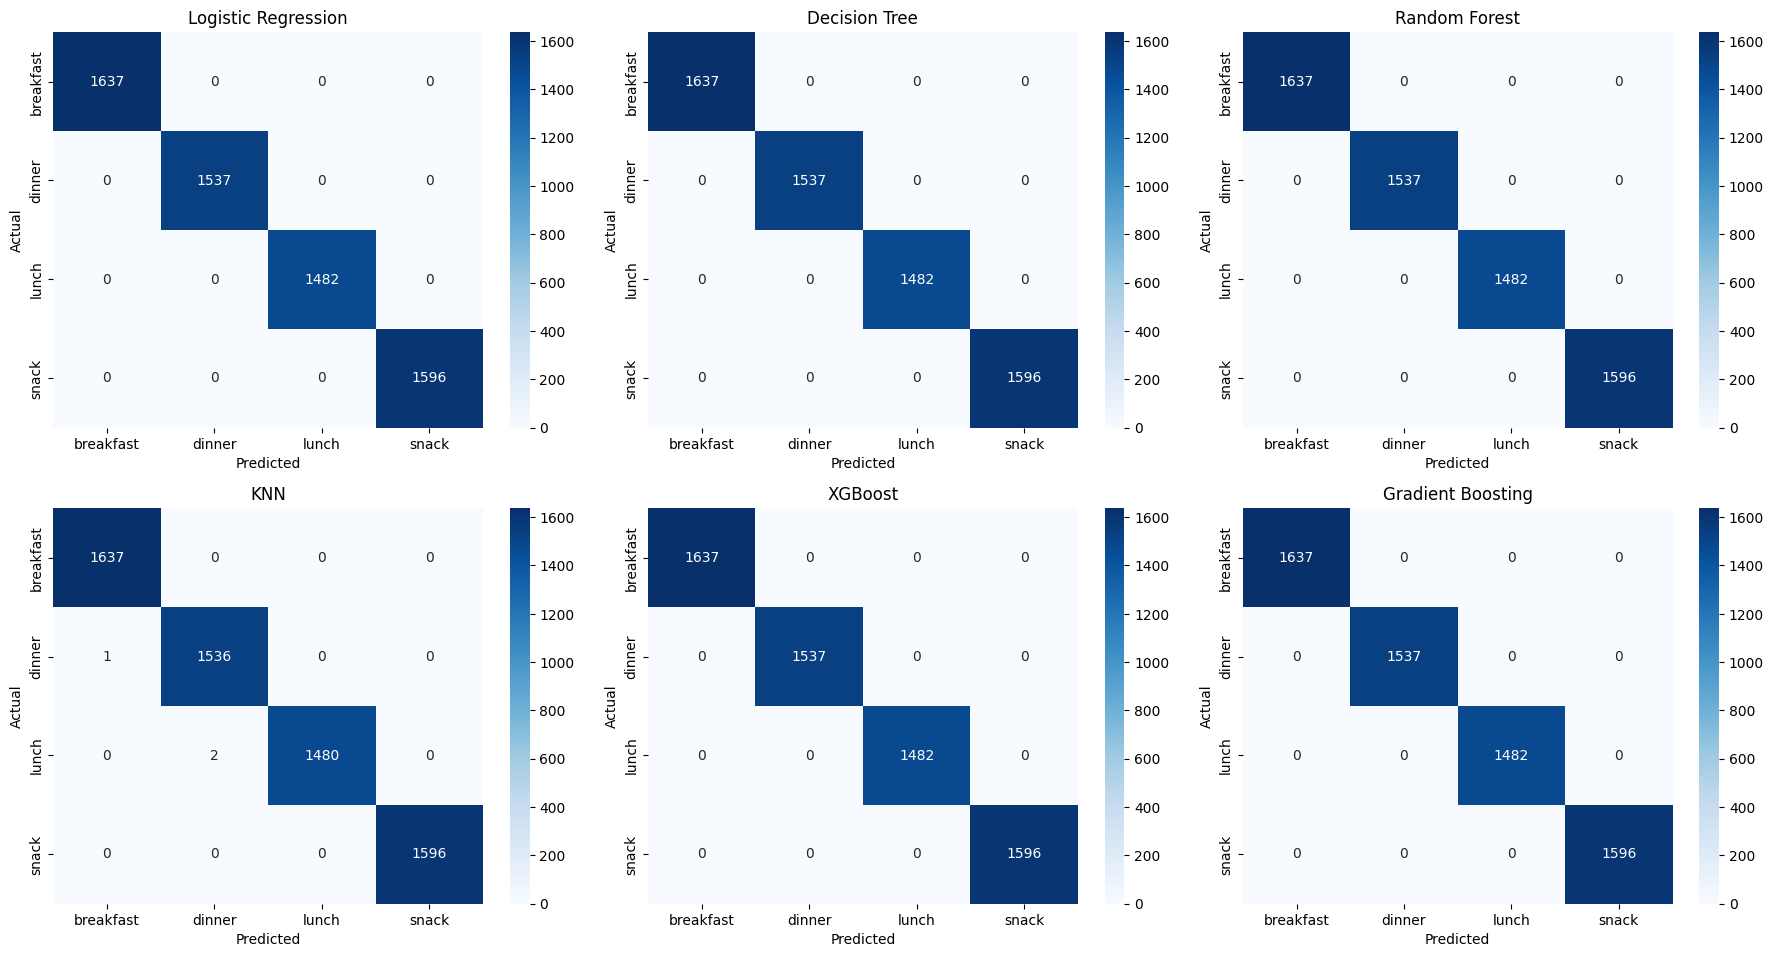

In [9]:
# Step 1: Feature Selection
X = df_clean.select_dtypes(include=['float64', 'int64'])  # Only numeric features
y = df_clean['Meal_Type_Label']

# Step 2: Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Step 4: Define Classifiers
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "KNN": KNeighborsClassifier(),
    "XGBoost": XGBClassifier(eval_metric='mlogloss', random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
    
}

# Step 5: Train and Evaluate Models
results = {}

for name, model in models.items():
    print(f"\n Training: {name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    print(f" Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

    results[name] = {
        "model": model,
        "accuracy": acc,
        "confusion_matrix": confusion_matrix(y_test, y_pred)
    }

# Step 6: Visualize Confusion Matrices
fig, axes = plt.subplots(3, 3, figsize=(18, 14))
axes = axes.flatten()

for i, (name, result) in enumerate(results.items()):
    sns.heatmap(result["confusion_matrix"], annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_,
                ax=axes[i])
    axes[i].set_title(name)
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("Actual")

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()